In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
measurement = Base.classes.measurement
station = Base.classes.station

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
m_cols = inspector.get_columns("measurement")
m_cols = [x["name"] for x in m_cols]
stn_cols = inspector.get_columns("station")
stn_cols = [x["name"] for x in stn_cols]
print("measurement:", m_cols)
print("station:", stn_cols)

measurement: ['id', 'station', 'date', 'prcp', 'tobs']
station: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [10]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date


('2017-08-23',)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = last_date = dt.datetime.strptime(latest_date[0], "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
start_date = dt.datetime(last_date.year - 1, last_date.month, last_date.day).date()

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_data, columns = ["Date", "Precipitation"]).set_index("Date").dropna()

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("Date")
prcp_df.head()



,Precipitation
Date,
2016-08-23,0.0
2016-08-23,0.5
2016-08-23,1.3
2016-08-23,17.8
2016-08-23,3.8


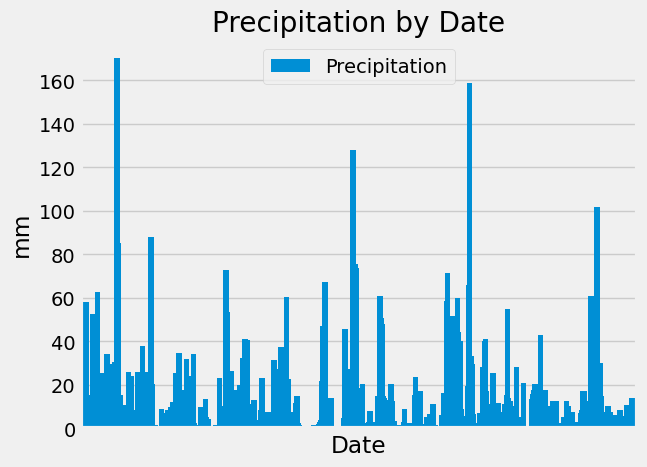

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind="bar", width=20, title="Precipitation by Date",
               legend=True, grid=True)

# remove x axis labels
plt.xticks([])
plt.xlabel("Date")
plt.ylabel("mm")

plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
stn_cnt = session.query(func.count(Station.station)).all()
stn_cnt

[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_most_active = station_count[0][0]
station_most_active

'USC00519281'

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
busy_station = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == station_most_active).\
    filter(Measurement.date >= start_date).all()

# convert to a dataframe
station_df = pd.DataFrame(busy_station)
station_df.head()

,date,tobs
0,2016-08-23,25.0
1,2016-08-24,25.0
2,2016-08-25,26.7
3,2016-08-26,26.7
4,2016-08-27,23.9


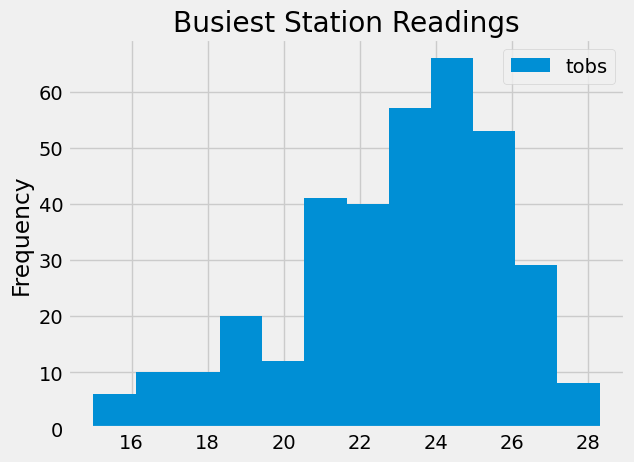

In [18]:
station_df["tobs"].plot(kind="hist", title="Busiest Station Readings", legend=True, bins=12)
plt.show()

# Close Session

In [19]:
# Close Session
session.close()